by Sonia Joseph

Twitter: [@soniajoseph_](https://twitter.com/soniajoseph_)

Original introduction is [here](https://www.lesswrong.com/posts/kobJymvvcvhbjWFKe/laying-the-foundations-for-vision-and-multimodal-mechanistic).

# Introduction

The purpose of this notebook is to introduce readers to vision transformer (ViT) mechanistic interpretability.

To make ViT mechanistic interpretability easier, I built an [open source library Prisma](https://github.com/soniajoseph/ViT-Prisma). The library is based on Neel Nanda's fantastic [TransformerLens](https://github.com/neelnanda-io/TransformerLens) but adapted for vision transformers and text-image models like CLIP. This notebook serves as a demo of the library. I highly encourage readers to check out the library and request features that they'd like to see!

I hope this notebook builds the vision mech interp ecosystem and encourages researchers to pursue their own directions with Prisma!

## Audience
This notebook is geared toward two audiences. The first is familiar with language mech interp, but not vision mech interp. The second is somewhat new to mechanistic interpretability, but is familiar with basic deep learning and has some mild exposure to mech interp concepts. If you are *completely* new to all mech interp, I recommend getting the basics down with the [ARENA curriculum](https://github.com/callummcdougall/ARENA_2.0) first.


The structure of this notebook is based on the excellent notebook [Exploratory Analysis](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=lZgu7cH72kdd) from TransformerLens, with some detours. While this notebook acts as a stand-alone, I encourage readers to consult the original notebook when they would like a deeper explanation.

For unfamiliar terms, also check out the [mech interp explorer](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#inline-images&theme=default).

## Structure

*See the sidebar for navigation.*

We'll run through the basic mech interp techniques on a vision transformer, including:

* Logit attribution
* Patch-level emoji logit lens
* Attention visualization
* Activation patching

**We will illustrate the last few technique by changing the ViT's prediction from tabby cat to Border Collie with a minimum viable ablation.**

## Acknowledgements and contributors

Thank you to Noah MacCallum, Rob Graham, and Karolis Ramanauskas for giving feedback on an early draft of this notebook.

Further thank you to Neel Nanda for your feedback, and to the Prisma team and core contributers, the MATS community, and South Park Commons. Full acknowledgements are on the Prisma repo documentation.


### Differences between ViT and Language Interpretability



*This section is geared toward readers already familiar with language transformer mech interp. If you are new to mech interp in general, you don't have to dwell on this section too much.*


Vision mech interp is like language mech interp, but in a fun-house mirror. Both architectures are transformers, so many LLM techniques carry over. However, there are a few twists:

* **The typical ViT is not doing unidirectional sequence modeling.** ViTs use bidirectional attention and predict a global CLS token, rather than predicting the next token in an autoregressive manner. (Note: There are autoregressive vision transformers with basically the same architecture as language, such as [Image GPT](https://openai.com/research/image-gpt) and [Parti](https://sites.research.google/parti/), which do next-token image generation. However, as of February 2024, autoregressive vision transformers are not frequently used in the wild.)
* **Bidirectional attention vs causal attention.** Language transformers have causal (unidirectional) attention. This means that there is an upper triangular mask on the attention, so that earlier tokens cannot attend to tokens in the future. The classical ViT, with its bidirectional attention, does not have the same concept of "time." Thus, some of the original LLM mech interp techniques break. It can be unclear which direction information is flowing. Induction heads, if they are present in vision, would look different from those in language to account for bidirectional attention.
* **CLS token instead of next token prediction/ autoregressive loss.** For ViTs, a learnable CLS token, which is prepended to the input, gets fed into the classification head instead of the final token as in language. The CLS token accrues global information from the other patches through self-attention as all the patches pass through the net.
* **No canonical dictionary matrix. Vision is more ambiguous.** Vision lacks a standard dictionary matrix like the 50k one for language, partially due to inherent ambiguity. For instance, a yellow patch on a goldfinch might represent "yellow," "wing," "goldfinch," "bird," or "animal," depending on the granularity, demonstrating hierarchical ambiguity. An animal might be identified specifically as a "Border collie" or more generally as a "dog." Beyond hierarchy, ambiguity in vision also stems from cultural interpretations and the imprecision of language. Practically, ImageNet's 1000 classes serve as a makeshift "dictionary," but it falls short of fully encompassing visual concepts.
* **Additional hyperparameters.** Patch size is a vision-specific hyperparameter, determining the size of the patches into which an image is divided. Using smaller patches increases accuracy but also computational load, because attention scales quadratically with patch number.
* **There is a zoo of vision transformers.** Similar to language, vision transformers come in many forms. The most relevant are the vanilla ViT, which we'll be analyzing in this notebook; CLIP, which is co-trained with text using contrastive loss; and DINO uses unlabeled data. For a review, check out [this survey](https://arxiv.org/pdf/2101.01169.pdf).


## Import libraries, data, and helper functions (ignore)

In [1]:
import vit_prisma
# from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT
# from vit_prisma.utils import prisma_utils

import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from vit_prisma.models.base_vit import HookedViT
import torchvision
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer




/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_31170/594584972.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Get images we'll feed into the model
!wget "https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/cat_dog.jpeg?raw=true" -O cat_dog.jpeg --quiet
!wget "https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/cat_crop.jpeg?raw=true" -O crop_cat.png --quiet


In [3]:
MODEL_NAME = "wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M"

**Helper Functions** (ignore)

In [4]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# transform = transforms.Compose([
#     ConvertTo3Channels(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transform = torchvision.transforms.Compose([
    ConvertTo3Channels(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=clip_processor.image_processor.image_mean,
                        std=clip_processor.image_processor.image_std),
])
transform_without_normalization = torchvision.transforms.Compose([
    ConvertTo3Channels(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

/Users/lukecadigan/miniconda3/envs/dsprites/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def plot_logit_boxplot(average_logits, labels):
  hovertexts = np.array([[IMAGENET_DICT[i] for _ in range(25)] for i in range(1000)])

  fig = go.Figure()
  data = []

  # if tensor, turn to numpy
  if isinstance(average_logits, torch.Tensor):
      average_logits = average_logits.detach().cpu().numpy()

  for i in range(average_logits.shape[1]):  # For each layer
      layer_logits = average_logits[:, i]
      hovertext = hovertexts[:, i]
      box = fig.add_trace(go.Box(
          y=layer_logits,
          name=f'{layer_labels[i]}',
          text=hovertext,
          hoverinfo='y+text',
          boxpoints='suspectedoutliers'
      ))
      data.append(box)


  means = np.mean(average_logits, axis=0)
  fig.add_trace(go.Scatter(
      x = layer_labels,
      y=means,
      mode='markers',
      name='Mean',
      # line=dict(color='gray'),
      marker=dict(size=4, color='red'),
  ))


  fig.update_layout(
      title='Raw Logit Values Per Layer (each dot is 1 ImageNet Class)',
      xaxis=dict(title='Layer'),
      yaxis=dict(title='Logit Values'),
      showlegend=False
  )

  fig.show()

In [6]:
def plot_patched_component(patched_head, title=''):
  """
  Use for plotting Activation Patching.
  """

  fig = go.Figure(data=go.Heatmap(
      z=patched_head.detach().numpy(),
      colorscale='RdBu',  # You can choose any colorscale
      colorbar=dict(title='Value'),  # Customize the color bar
      hoverongaps=False
  ))
  fig.update_layout(
      title=title,
      xaxis_title='Attention Head',
      yaxis_title='Patch Number',
  )

  return fig

def imshow(tensor, **kwargs):
    """
    Use for Activation Patching.
    """
    px.imshow(
          prisma_utils.to_numpy(tensor),
          color_continuous_midpoint=0.0,
          color_continuous_scale="RdBu",
          **kwargs,
      ).show()


# Load model and data

## ViT Architecture

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)


A [vision transformer](https://arxiv.org/pdf/2010.11929.pdf) (ViT) is an architecture designed for image classification tasks, similar to the classic transformer architecture used in language models. A ViT consists of transformer blocks; each block consists of an Attention layer and an MLP layer.


Unlike language models, vision transformers do not have a dictionary embedding and unembedding matrix. Instead, images are divided into non-overlapping patches, similar to tokens in language models. These patches are flattened and linearly projected to embeddings via a Conv2D layer, similar to word embeddings in language models. A learnable class token (CLS token) is appended to the beginning of the sequence, which accrues global information throughout the network. A linear position embedding is added to the patches.

The patch embeddings then pass through the transformer blocks (each block consists of a layer norm, an attention layer, another layernorm, and an mlp layer). The output of each block is added back to the previous input. The sum of the block and the previous input is called the residual stream.

The final layer of this vision transformer is a classification head with 1000 logit values for ImageNet's 1000 classes. The CLS token is fed into the final layer for 1000-way classification.

Like TransformerLens, we use HookedViT to easily capture intermediate activations with custom hook functions, instead of dealing with PyTorch's normal hook functionality.



In [7]:
clip_model = CLIPModel.from_pretrained(MODEL_NAME)

In [8]:
model = HookedViT.from_pretrained(MODEL_NAME, is_timm=False, is_clip=True)

{'n_layers': 12, 'd_model': 512, 'd_head': 64, 'model_name': '', 'n_heads': 8, 'd_mlp': 2048, 'activation_name': 'gelu', 'eps': 1e-05, 'original_architecture': 'vit_clip_vision_encoder', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 512, 'n_params': None, 'layer_norm_pre': True, 'return_type': 'class_logits'}
LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model wkcn/TinyCLIP-ViT-40M-32-Text-19M-LAION400M into HookedTransformer


## Load data

For this specific transformer, ImageNet's 1000 classes serve as a rough equivalent to a language dictionary, but it's important to remember that these classes don't fully encompass all visual concepts, unlike more expansive models like CLIP.

<details> <summary>On the ambiguities of vision </summary>

Vision introduces unique ambiguities not found in language, including hierarchical ambiguity (e.g., identifying a black dog paw at varying levels of specificity), cultural ambiguity (where different cultures may label images differently), and precision ambiguity (where terms like "object" can refer to a wide range of items). While exploring language's ambiguity is beyond this notebook's focus, it's a recurring team in non-language interpretability.

</details>

For now, we will keep things simple and just deal with 1000-way ImageNet. Let's load our image.


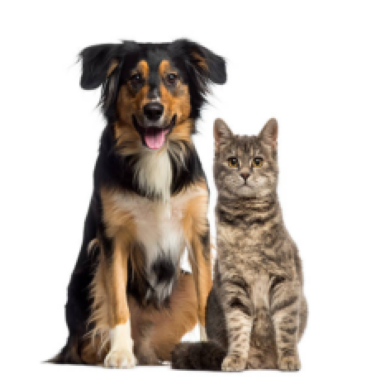

In [227]:
raw_image = Image.open('cat_dog.jpeg')
image = transform_without_normalization(raw_image)
image_tensor = transform(raw_image)
plot_image(image)

We'll use an image with both a Border Collie and a tabby cat. I'm curious how the classifier represents each animal throughout the net and 'decides' between the two animals for its final classification.

For the sake of this demo, we'll just use one image. However, a more comprehensive analysis would use several images instead of one.






We divide our 224 x 224 image into 32 x 32 non-overlapping patches to feed into the transformer. The transformer also appends a CLS token at the beginning, which is not represented spatially. In total, including the CLS token, there are 50 patches for the image.

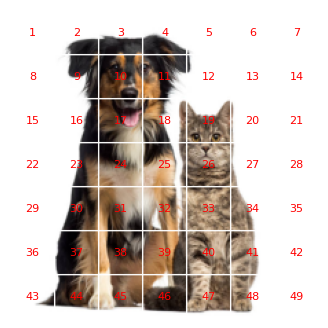

In [228]:
from vit_prisma.visualization.visualize_image import display_grid_on_image

display_grid_on_image(image, patch_size=32)

## Test prompt

Let's feed the image into the transformer and investigate its top logits.

In [267]:
# from vit_prisma.utils.data_utils.imagenet_utils import imagenet_index_from_word
# from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils.prisma_utils import test_prompt


interesting_words=["fluffy", "scaly", "smooth", "standing", "woman","cute","cat", "dog" ]

IMAGENET_DICT={key: value for key, value in enumerate(interesting_words)}

print(IMAGENET_DICT)
WORD_TO_KEY_DICT = {value: key for key, value in IMAGENET_DICT.items()}
def imagenet_index_from_word(word):
    return WORD_TO_KEY_DICT[word]




{0: 'fluffy', 1: 'scaly', 2: 'smooth', 3: 'standing', 4: 'woman', 5: 'cute', 6: 'cat', 7: 'dog'}


In [268]:


# print(len(IMAGENET_DICT.keys()))
# IMAGENET_DICT[len(IMAGENET_DICT.keys())]="animal"
# IMAGENET_DICT[len(IMAGENET_DICT.keys())]="happy"
# IMAGENET_DICT[len(IMAGENET_DICT.keys())]="sad"

# print(len(IMAGENET_DICT.keys()))
# print(IMAGENET_DICT[1000])

In [269]:
list(IMAGENET_DICT.values())[:10]

['fluffy', 'scaly', 'smooth', 'standing', 'woman', 'cute', 'cat', 'dog']

In [270]:
CLASS_PROMPTS = [f"this is a {c} image" for c in IMAGENET_DICT.values()]
CLASS_PROMPTS[0]

'this is a fluffy image'

In [271]:
# CLASS_PROMPTS_SINGLE = [f"a portrait of a {c.split(',')[0]}" for c in IMAGENET_DICT.values()]
# CLASS_PROMPTS_SINGLE[0]

In [272]:
# CLASS_PROMPTS_SINGLE[281]

In [273]:
# CLASS_PROMPTS[281]

In [274]:
text_tokens = clip_processor(text=CLASS_PROMPTS, return_tensors="pt", padding=True)
text_features = clip_model.get_text_features(**text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [275]:
# text_tokens_single = clip_processor(text=CLASS_PROMPTS_SINGLE, return_tensors="pt", padding=True)
# text_features_single = clip_model.get_text_features(**text_tokens_single)
# text_features_single /= text_features_single.norm(dim=-1, keepdim=True)

In [276]:
def test_prompt(example_data_point, model, text_features, example_answers=None, top_k=10):

    image_features = model(example_data_point)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    # values, indices = similarity[0].topk(top_k)
    logits = similarity

    probs = logits.softmax(dim=-1)
    probs = probs.squeeze(0).detach().numpy()
    sorted_probs = np.sort(probs)[::-1]
    sorted_probs_args = np.argsort(probs)[::-1]

    for i in range(top_k):
        index = sorted_probs_args[i]
        prob = sorted_probs[i]
        logit = logits[0, index].item()  # Assuming you want to show the original logit value
        print("index is ",index)
        label = IMAGENET_DICT[index]  # Adjust based on your mapping

        rank_str = f"Top {i}th token."
        logit_str = f"Logit: {logit:.2f}"
        prob_str = f"Prob: {prob * 100:.2f}%"
        token_str = f"Label: |{label}|"

        print(f"{rank_str} {logit_str} {prob_str} {token_str}")

    if example_answers:
      for example_answer in example_answers:
        tabby_cat_idx = imagenet_index_from_word(example_answer)

      # Example for displaying ranks of the answer tokens, adjust according to your needs
        answer_index = imagenet_index_from_word(example_answer)
        answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
        print("Rank of the correct answer:")
        for ans_index in answer_indices:
            rank = np.where(sorted_probs_args == ans_index)[0][0]
            print(f"Class Name: {example_answer} | Rank: {rank} | ImageNet Index: {tabby_cat_idx}")

In [277]:
test_prompt(image_tensor.unsqueeze(0), model, text_features, example_answers=interesting_words, top_k=2)

index is  7
Top 0th token. Logit: 0.64 Prob: 20.36% Label: |dog|
index is  6
Top 1th token. Logit: 0.23 Prob: 13.55% Label: |cat|
Rank of the correct answer:
Class Name: fluffy | Rank: 2 | ImageNet Index: 0
Rank of the correct answer:
Class Name: scaly | Rank: 6 | ImageNet Index: 1
Rank of the correct answer:
Class Name: smooth | Rank: 4 | ImageNet Index: 2
Rank of the correct answer:
Class Name: standing | Rank: 5 | ImageNet Index: 3
Rank of the correct answer:
Class Name: woman | Rank: 7 | ImageNet Index: 4
Rank of the correct answer:
Class Name: cute | Rank: 3 | ImageNet Index: 5
Rank of the correct answer:
Class Name: cat | Rank: 1 | ImageNet Index: 6
Rank of the correct answer:
Class Name: dog | Rank: 0 | ImageNet Index: 7


In [278]:
# test_prompt(image_tensor.unsqueeze(0), model, text_features_single, example_answers=["tabby", "Bernese mountain dog"], top_k=2)

Previous conclusion
> We can see that the net predicts tabby and Bernese mountain dog as the two most probable classes! This is close-to-accurate! The other candidates are various other dogs and cats.
> 
> I am curious why the net decides the overall image is a tabby instead of a dog, when both animals are present. I'd naively expect the net to classify the image as dog because are more patches containing the dog.
> 
> Let's run the model again and cache all the intermediate activations.

Current conclusion

We can see that the model mostly predicts dogs, while it just starts to predict cat at pos 14


In [279]:
logit_scale = clip_model.logit_scale.exp()

In [280]:
# Run Cache
image_features, cache = model.run_with_cache(image_tensor.unsqueeze(0))
normalized_image_features = image_features / image_features.norm(dim=-1, keepdim=True)
logits = logit_scale * normalized_image_features @ text_features.T

In [281]:
IMAGENET_DICT[0]

'fluffy'

In [282]:
# plot scatter plot of logits, x axis is the class index, y axis is the logit value
import plotly.express as px
import plotly.graph_objects as go

left_index = 0
right_index = 1

# only plot [left_index, right_index] classes
logits_np = logits.softmax(dim=-1).squeeze(0).detach().numpy()
logits_np = logits_np[left_index:right_index+1]
class_indices = np.arange(left_index, right_index+1)
class_names = [IMAGENET_DICT[i] for i in class_indices]
fig = px.scatter(x=class_names, y=logits_np, labels={'x': 'Class Index', 'y': 'Logit Value'}, title='Logit Value for Each Class')
fig.show()




# Logit Attribution

We want to see how each internal component of the model is impacting its output. Direct logit attribution is a powerful technique to do so.

<details> <summary>Background</summary>

Compared to past architectures like CNNs and RNNs, transformers are unusually interpretable. This is partially because transformers are highly linear, which means we can easily decompose the output of each layer into the contributions of its previous parts.

The residual stream of the transformer is the cumulative sum of the outputs of the previous layers, plus the original patch and position embedding.

The output of each attention layer can be decomposed into a sum of the attention heads; and the output of each MLP layer can be decomposed into the sum of each neuron.

The final logits of the model are `logits=ClassificationHead(LayerNorm(final_residual_stream)`. The classification head is a linear layer, and the LayerNorm is *approximately* a linear layer. Thus, we can decompose the logits into the sum of components, and see which components contribute most to the logit of the correct answer.

For example, the tabby cat logit has an index of 281 in our 1000-logit classification head. We can decompose the transformer to see which components of the transformer (MLP layers, attention heads, etc) contribute most strongly to the tabby cat logit.

For details on the linear structure of transformer, check out [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html).

For more details on direct logit attribution, check out the mech interp explainer [here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=disz2gTx-jooAcR0a5r8e7LZ) and the original Exploratory Analysis notebook [here](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=tGz70kpdiPzs).

<details> <summary> Folding LayerNorm </summary>

The original LayerNorm implementation, which is a center and scale, messes with the linearity described above. The LayerNorm is almost a linear operation except for the scaling factor; but thankfully, if we fix the scale factor, then it becomes a global property. Thus, we can create an approximation of the LayerNorm that factors out the linear parts with 'fold_ln' when we load the model, and we can move the scaling factor to the end of the residual stream as a global computation with 'apply_ln'.
For more information, check out the [original rationale](https://github.com/neelnanda-io/TransformerLens/blob/main/further_comments.md) on TransformerLens.
</details>



Let's snag the ImageNet indexes for tabby and border collie.

<details> <summary> An aside on superclasses </summary>
It's possible to run our analysis with superclasses (e.g. cats vs dogs), whose coarser granularity may more readily reveal properties of the model. However, we'll leave that for a future exercise and focus on these two specific classes.
</details>

In [283]:
## Accumulated residual

interesting_indexes = [imagenet_index_from_word(interesting_word) for interesting_word in interesting_words]


for i, interesting_index in enumerate(interesting_indexes):
    print(interesting_words[i]," index ", interesting_index)



fluffy  index  0
scaly  index  1
smooth  index  2
standing  index  3
woman  index  4
cute  index  5
cat  index  6
dog  index  7


Let's get the residual directions of the tabby and Border Collie.

The residual directions are simply indexing into the classication head, which is represented as a 768 x 1000 matrix. We take the columns that correspond with the cat and dog indices. We're taking these size 768 vectors as our residual directions.

In [284]:
import einops
def tokens_to_residual_directions_clip(model: HookedViT, labels, text_features: torch.Tensor):
    
    answer_residual_directions = model.head.W_H[:,labels]  
    answer_residual_directions = einops.rearrange(
                    answer_residual_directions, "d_model ... -> ... d_model"
                )
    
    return answer_residual_directions

In [285]:
model.head.W_H.shape # (d_model, num_classes) for vit (d_model, d_model) for clip

torch.Size([512, 512])

In [286]:

# Put 0 to get CLS token at beginning
cls_token_residual_stream = cache["resid_post", -1][:, 0, :]
scaled_final_token_residual_stream = cache.apply_ln_to_stack(cls_token_residual_stream, layer=-1, pos_slice=0 )
# Note: We can also use the cache result
torch.allclose(scaled_final_token_residual_stream, cache["ln_final.hook_normalized"][:,0,:])

True

In [287]:
pre_proj_cls_token = cache["ln_final.hook_normalized"][:,0,:]
pre_proj_cls_token.shape

torch.Size([1, 512])

In [288]:
def get_W_H(
    model: HookedViT,
    token: torch.Tensor,
    normalized_text_features: torch.Tensor,
    logit_scale: torch.Tensor,
) -> torch.Tensor:
    n = (token @ model.head.W_H + model.head.b_H).norm(dim=-1, keepdim=True)
    scaled_text_features = logit_scale * normalized_text_features.T
    return model.head.W_H / n @ scaled_text_features


def get_b_H(
    model: HookedViT,
    token: torch.Tensor,
    normalized_text_features: torch.Tensor,
    logit_scale: torch.Tensor,
) -> torch.Tensor:
    n = (token @ model.head.W_H + model.head.b_H).norm(dim=-1, keepdim=True)
    scaled_text_features = logit_scale * normalized_text_features.T
    return model.head.b_H / n @ scaled_text_features

"""
post_proj_cls = clstok @ model.head.W_H + model.head.b_H
c = (clstok @ model.head.W_H + model.head.b_H).norm(dim=-1, keepdim=True)
scaled_text_features = logit_scale * text_features.T
logits_2 = clstok @ (model.head.W_H/c @ scaled_text_features) + model.head.b_H/c @ scaled_text_features
"""


def tokens_to_residual_directions(
    model: HookedViT,
    indices: np.ndarray,
    token: torch.Tensor,
    normalized_text_features: torch.Tensor,
    logit_scale: torch.Tensor,
):
    new_W_H = get_W_H(model, token, normalized_text_features, logit_scale)
    return new_W_H.T[indices]

In [289]:
def get_logits_from_pre_proj_cls(
    model: HookedViT,
    pre_proj_cls_token: torch.Tensor,
    normalized_text_features: torch.Tensor,
    logit_scale: torch.Tensor,
):
    post_proj_cls_token = (pre_proj_cls_token @ model.head.W_H + model.head.b_H)
    post_proj_cls_token /= post_proj_cls_token.norm(dim=-1, keepdim=True) # also called image_features on clip lingo
    logits = logit_scale * post_proj_cls_token @ normalized_text_features.T
    return logits

In [290]:
clstok = cache["ln_final.hook_normalized"][:, 0, :]
logits_v2 = get_logits_from_pre_proj_cls(model, clstok, text_features, logit_scale)
logits_v3 = clstok @ get_W_H(model, clstok, text_features, logit_scale) + get_b_H(
    model, clstok, text_features, logit_scale
)
print(torch.allclose(logits, logits_v2))
print(torch.allclose(logits, logits_v3, atol=1e-5))

True
True


In [291]:

interesting_residual_directions = [tokens_to_residual_directions(model, index, clstok, text_features, logit_scale) for index in interesting_indexes]



To check that our residual directions are correct, we can dot product them with the model's final residual stream. The answer should equal the raw logit value if we indexed directly into the model's output logits.

In [292]:
get_b_H(model, scaled_final_token_residual_stream, text_features, logit_scale).shape

torch.Size([1, 8])

In [293]:

# Confirm manually
final_residual_stream = cache["resid_post", -1]

# Put 0 to get CLS token at beginning
cls_token_residual_stream = final_residual_stream[:, 0, :]

scaled_final_token_residual_stream = cache.apply_ln_to_stack(cls_token_residual_stream, layer=-1, pos_slice=0 )


b_H = get_b_H(model, scaled_final_token_residual_stream, text_features, logit_scale)[0]

interesting_logits = [einsum(
    "batch d_model, d_model -> batch",
    scaled_final_token_residual_stream,
    residual_direction,
) for residual_direction in interesting_residual_directions]


for i, index in enumerate(interesting_indexes):
    interesting_logits[i] += b_H[interesting_indexes[i]] 

# print("Calculated tabby cat logit value:", round(happy_logit.item(), 3))
# print("Tabby cat logit value taken directly from model's output logits:", round(logits[:,happy_index].item(),3))
# print()

# sad_logit += b_H[sad_index]
# print("Calculated Border collie logit value:", round(sad_logit.item(), 3))
# print("Border collie logit value taken directly from model's output logits:", round(logits[:,sad_index].item(), 3))

## All Logit Values

We can project every intermediate CLS token output from each layer onto the residual directions. This is the equivalent of directly feeding the CLS output of each layer into the 1000-way classification head to get a logit value for each class.

In [294]:
def average_logit_value_across_all_classes(
    residual_stack,
    cache,
    mean = True,
):
    scaled_residual_stack = cache.apply_ln_to_stack(
            residual_stack, layer=-1, pos_slice=0
        )
    logit_predictions = []
    for layer_res in scaled_residual_stack:
       res = get_logits_from_pre_proj_cls(model, layer_res, text_features, logit_scale)
       logit_predictions.append(res)
    logit_predictions = torch.stack(logit_predictions, dim=-1).squeeze(0)

    if mean:
      logit_predictions = logit_predictions.mean(axis=0)

    return logit_predictions

accumulated_residual, layer_labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=0, return_labels=True
    )
average_logits = average_logit_value_across_all_classes(accumulated_residual, cache, mean=False)


We can see that the final attention layer most significantly changes the distribution of logits! The plot is interactive; hover your mouse over the outliers to see the class names.z

**Key for graph below**
* n_pre - residual stream at start of layer n
* n_mid - residual stream after attention part of layer
* final_post - residual stream after final mlp layer (before classification head)

<details>
<summary><i>Note on raw logit metric for more experienced mech interp people</i></summary>

The logit difference between two classes, rather than the raw logit value itself, is often considered a more reliable measure. This is because when subtracting one logit from another, any arbitrary constants inherent in the logits cancel out. The design of cross-entropy loss focuses specifically on the differences between class logits, which can result in the logits being adjusted by an arbitrary constant. For a more in-depth explanation, refer to the mechanism interpretation explainer [here](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=disz2gTx-jooAcR0a5r8e7LZ) or the original Exploratory Analysis notebook [here](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb#scrollTo=tGz70kpdiPzs).

Contrary to the initial Indirect Object Identification (IOI) analysis, which focuses on the logit differences between two classes, my approach considers the raw logit value of a single class. Observing a box plot of all logit values reveals that, on average, the values are near zero for every layer (indicated by the red dot). Therefore, the notion of biases neutralizing each other, as seen in the logit difference case, does not hold here since the average logit value is zero.




</details>



In [295]:
# average_logits.shape

In [296]:
# plot_logit_boxplot(average_logits, layer_labels)

### Layer-Level Logit lens
We'll now project every layer of the image's residual stream onto the residual directions. We'll use just the CLS token for this analysis.

This is analogous to deleting all subsequent layers and just projecting that layer's output into the classification head. This will tell us the likelihood the net assigns to each class throughout the net.

Let's also grab a random logit, like banana, for comparison. We'll also get the average of all logits as a baseline.

In [297]:
# misc_index = imagenet_index_from_word("banana")
# print("Banana index:", misc_index)
# misc_residual_direction = tokens_to_residual_directions(model, misc_index, clstok, text_features, logit_scale)

In [298]:
# life_index=imagenet_index_from_word("life")
# pet_index=imagenet_index_from_word("pet")
# edge_index=imagenet_index_from_word("edge")
# animal_index=imagenet_index_from_word("animal")


# life_residual_direction = tokens_to_residual_directions(model, life_index , clstok, text_features, logit_scale)
# pet_residual_direction = tokens_to_residual_directions(model, pet_index, clstok, text_features, logit_scale)
# edge_residual_direction = tokens_to_residual_directions(model, edge_index, clstok, text_features, logit_scale)
# animal_residual_direction = tokens_to_residual_directions(model, animal_index, clstok, text_features, logit_scale)



interesting_residual_directions = [tokens_to_residual_directions(model, index, clstok, text_features, logit_scale) for index in interesting_indexes]




# animal_residual_direction = tokens_to_residual_directions(model, pet_index, clstok, text_features, logit_scale)


Let's plot the logit values for tabby cat, Border collie, and banana throughout the layers.

In [299]:
def residual_stack_to_logit(
    residual_stack,
    cache,
):
    scaled_residual_stack = cache.apply_ln_to_stack(
            residual_stack, layer=-1, pos_slice=0
        )
    logit_predictions = []
    for layer_res in scaled_residual_stack:
       res = get_logits_from_pre_proj_cls(model, layer_res, text_features, logit_scale)
       logit_predictions.append(res)
    logit_predictions = torch.stack(logit_predictions, dim=-1).squeeze(0)
    return logit_predictions

accumulated_residual, layer_labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=0, return_labels=True
)

The plot below is interactive. Run your cursor over the layers to see the corresponding logit value.

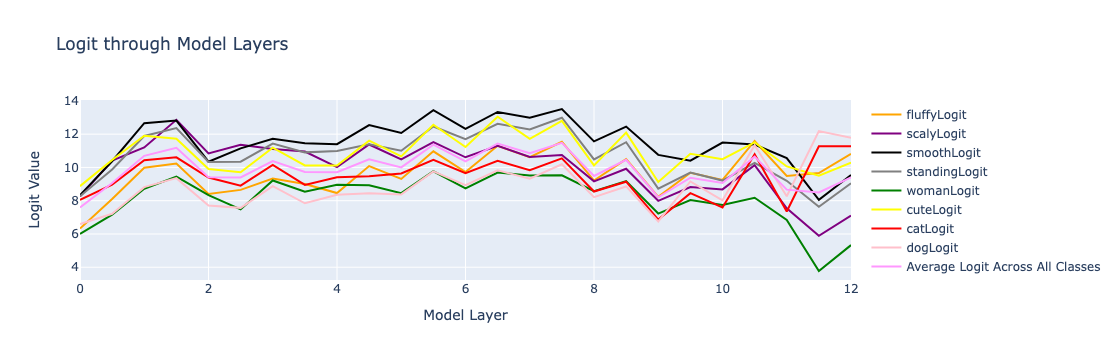

In [306]:
fig = go.Figure()

residual_directions = [
#     # (cat_answer_residual_direction, 'Tabby Cat Logit', 'grey', cat_index), # Grey for Tabby Cat
#     # (dog_answer_residual_direction, 'Border Collie Logit', 'brown', dog_index), # Brown for Border Collie
#     # (misc_residual_direction, 'Banana Logit', 'goldenrod', misc_index), # Yellow-Orange for Banana
#     # (life_residual_direction, 'Life Logit', 'red', life_index), # Yellow-Orange for Banana
#     # (pet_residual_direction, 'Pet Logit', 'black', pet_index), # Yellow-Orange for Banana
#     # (edge_residual_direction, 'Edge Logit', 'blue', edge_index), # Yellow-Orange for Banana
#     # (animal_residual_direction, 'Animal Logit', 'green', edge_index), # Yellow-Orange for Banana
    (interesting_residual_directions[0], interesting_words[0]+'Logit', 'orange', interesting_indexes[0]), # Yellow-Orange for Banana
    (interesting_residual_directions[1], interesting_words[1]+'Logit', 'purple', interesting_indexes[1]), # Yellow-Orange for Banana
    (interesting_residual_directions[2], interesting_words[2]+'Logit', 'black', interesting_indexes[2]), # Yellow-Orange for Banana
    (interesting_residual_directions[3], interesting_words[3]+'Logit', 'grey', interesting_indexes[3]), # Yellow-Orange for Banana
    (interesting_residual_directions[4], interesting_words[4]+'Logit', 'green', interesting_indexes[4]), # Yellow-Orange for Banana
    (interesting_residual_directions[5], interesting_words[5]+'Logit', 'yellow', interesting_indexes[5]), # Yellow-Orange for Banana
    (interesting_residual_directions[6], interesting_words[6]+'Logit', 'red', interesting_indexes[6]), # Yellow-Orange for Banana
    (interesting_residual_directions[7], interesting_words[7]+'Logit', 'pink', interesting_indexes[7]), # Yellow-Orange for Banana
]



hover_text = [f"{layer_labels[idx]}" for idx, diff in enumerate(accumulated_residual)]

# Process each residual direction
for direction, label, color, ix in residual_directions:
    # logit_predictions = residual_stack_to_logit(accumulated_residual, cache, direction)
    # logit_predictions = logit_predictions.T + bias  # Add bias
    # logit_predictions = logit_predictions.detach().numpy()
    logit_predictions = residual_stack_to_logit(accumulated_residual, cache).detach().numpy()
    logit_predictions = logit_predictions[ix]
    fig.add_trace(go.Scatter(x= np.arange(model.cfg.n_layers * 2 + 1) / 2, y=logit_predictions, mode='lines', name=label, text=hover_text, line=dict(color=color)))

# Handle "Average Logit Across All Classes" separately
average_total_logits = average_logit_value_across_all_classes(accumulated_residual, cache).detach().numpy()
fig.add_trace(go.Scatter(x= np.arange(model.cfg.n_layers * 2 + 1) / 2, y=average_total_logits, mode='lines', name='Average Logit Across All Classes'))

fig.update_layout(
    title="Logit through Model Layers",
    xaxis_title="Model Layer",
    yaxis_title="Logit Value",
)

fig.show()


We can see the model doesn't really weight the Border Collie prediction too highly until Layer 8! The prediction is around equal to the banana prediction. Interestingly, it takes until Layer 8 for the model to decide that the image is *not* a banana.

In [301]:
import plotly.graph_objects as go

# Assuming `cache`, `average_logit_value_across_all_classes`, `residual_stack_to_logit`, and other necessary functions and variables are defined elsewhere

# Retrieve the per-layer residual and labels
per_layer_residual, layer_labels = cache.decompose_resid(
    layer=-1, pos_slice=0, return_labels=True
)

# Initialize the figure
fig = go.Figure()

# Iterate over each residual direction and its corresponding label
for direction, label, color, ix in residual_directions:
    per_layer_logit_diffs = residual_stack_to_logit(per_layer_residual, cache)
    per_layer_logit_diffs = per_layer_logit_diffs[ix]
    per_layer_logit_diffs = per_layer_logit_diffs.detach().numpy()  # Assuming you want the first element for some reason; adjust if necessary
    hover_text = [f"{layer_labels[idx]}" for idx, diff in enumerate(per_layer_logit_diffs)]
    fig.add_trace(go.Scatter(y=per_layer_logit_diffs, mode='lines', name=label, text=hover_text, line=dict(color=color)))

# Handle average logits across all classes
average_total_logits = average_logit_value_across_all_classes(per_layer_residual, cache).detach().numpy()
fig.add_trace(go.Scatter(y=average_total_logits, name="Average Logit Across All Labels"))

# Update layout with appropriate titles
fig.update_layout(
    title="Logit through Model Layers",
    xaxis_title="Layer",
    yaxis_title="Logit Difference",
)

# Display the plot
fig.show()


We can do the same analysis above, but for each layer. This is equivalent to taking the difference between each adjacent residual stream.

We can see that the final attention layer does the most work in deciding the computation. The subsequent MLP layer actually makes its performance worse!

The last four layers seem to being the bulk of the work in identifying the cat and the dog.

## Patch-level logit lens

We ran the analysis above on just the CLS token of the model. But we actually have 49 other patches that we haven't investigated yet.

(As a reminder, our 224 x 224 image was divided into 50 non-overlapping patches. Each patch is 32 x 32. The patches are analogous to tokens in an LLM.)

The attention layers move information between patches, while the MLP layers process information within each patch. One open question in vision mech interp is what each patch represents throughout the net, and how information moves between the patches. How is information "gathered" across a cat whisker, cat ear, and cat eye to lead to a cat classification? Does every patch contain local information from the original image, even in the last layers of the net? For instance, does a patch initially containing a dog ear retain dog ear information, even after 12 layers of global self-attention? Or does it start storing higher abstractions, such as, dog face information, and dog breed information?

A patch-level logit lens is a good starting point to investigate these questions. The patch-level logit lens is the same as the analysis done above, but run on every patch instead of just the CLS token.

We'll soon see that each patch encodes information (mostly) locally, to the extent that we can use the patch-level logit lens as a segmentation map.

In [302]:
from vit_prisma.prisma_tools.logit_lens import get_patch_logit_directions, get_patch_logit_dictionary

In [303]:
def get_patch_logit_directions_v2(cache, indices, incl_mid=False, return_labels=True):
    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=incl_mid, return_labels=True
    )
    scaled_residual_stack = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,
    )
    # result = torch.einsum('lbpd,od -> lbpo', scaled_residual_stack, all_answers)

    # Rearrange so batches are first
    result = residual_stack_to_logit(scaled_residual_stack, cache).unsqueeze(0)
    result = result.permute(0, 1, 3, 2)
    return result, labels

def get_patch_logit_dictionary_v2(patch_logit_directions, batch_idx=0, rank_label=None):
    patch_dictionary = defaultdict(list)
    # if tuple, get first entry
    if isinstance(patch_logit_directions, tuple):
        patch_logit_directions = patch_logit_directions[0]
    # Go through laeyrs of one batch
    for patch_idx, patches in enumerate(patch_logit_directions[batch_idx]):
        # Go through every patch and get max prediction
        for logits in patches:
            probs = torch.softmax(logits, dim=-1)
            # Get index of max prediction
            predicted_idx = int(torch.argmax(probs))
            logit = logits[predicted_idx].item()
            predicted_class_name = IMAGENET_DICT[predicted_idx]
            if rank_label:
                # Where is the rank_label in the sorted list?
                rank_index = imagenet_index_from_word(rank_label)
                sorted_list = torch.argsort(probs, descending=True)
                rank = np.where(sorted_list == rank_index)[0][0]
                patch_dictionary[patch_idx].append((logit, predicted_class_name, predicted_idx, rank))
            else:
                patch_dictionary[patch_idx].append((logit, predicted_class_name, predicted_idx))
    return patch_dictionary


In [304]:
# Can also import the above as functions; displayed in full above for didactic purposes.
# from vit_prisma.prisma_tools.logit_lens import get_patch_logit_directions, get_patch_logit_dictionary

all_answers = tokens_to_residual_directions(model, np.arange(len(IMAGENET_DICT)), clstok, text_features, logit_scale)
patch_logit_directions = get_patch_logit_directions(cache, all_answers, incl_mid=True)

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, rank_label=IMAGENET_DICT[0])
print("Length of patch dictionary:", len(patch_dictionary)) # Number of patches
print("Length of one dictionary entry:", len(list(patch_dictionary.values())[0])) # Layers

tabby_rank_formatted = np.array([[item[-1] for item in list(patch_dictionary.values())[i]] for i in range(50)])

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, rank_label=IMAGENET_DICT[1])
collie_rank_formatted = np.array([[item[-1] for item in list(patch_dictionary.values())[i]] for i in range(50)])

ValueError: 'fluffy' not found in IMAGENET_DICT.

In [ ]:
# Can also import the above as functions; displayed in full above for didactic purposes.
# from vit_prisma.prisma_tools.logit_lens import get_patch_logit_directions, get_patch_logit_dictionary

patch_logit_directions_v2 = get_patch_logit_directions_v2(cache, np.arange(1000), incl_mid=True)

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions_v2, rank_label='tabby')
print("Length of patch dictionary:", len(patch_dictionary)) # Number of patches
print("Length of one dictionary entry:", len(list(patch_dictionary.values())[0])) # Layers

tabby_rank_formatted = np.array([[item[-1] for item in list(patch_dictionary.values())[i]] for i in range(50)])

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions_v2, rank_label='collie')
collie_rank_formatted = np.array([[item[-1] for item in list(patch_dictionary.values())[i]] for i in range(50)])

In [ ]:
import plotly.graph_objs as go
import numpy as np

# Initialize traces list for Plotly
traces = []

# Define colors with darker shades
colors = {
    'tabby': {'cls_color': 'rgba(0, 0, 255, 1.0)', 'patch_color': 'rgba(169, 169, 169, 0.5)'},
    'collie': {'cls_color': 'rgba(255, 0, 0, 1.0)', 'patch_color': 'rgba(218, 165, 32, 0.5)'},
}

# Data setup for each class
data_classes = [
    {'name': 'tabby', 'data': tabby_rank_formatted},
    {'name': 'collie', 'data': collie_rank_formatted},
]

# Processing both classes in a single loop
for class_info in data_classes:
    rank_data = class_info['data']
    class_name = class_info['name']
    cls_color = colors[class_name]['cls_color']
    patch_color = colors[class_name]['patch_color']

    for i, patch_data in enumerate(rank_data):
        color = cls_color if i == 0 else patch_color
        width = 2 if i == 0 else 1
        mode = 'lines+markers' if i == 0 else 'lines'
        trace = go.Scatter(
            x=np.arange(len(patch_data) * 2 + 1) / 2,
            y=patch_data,
            mode=mode,
            line=dict(color=color, width=width),
            hoverinfo='text',
            text=[f'Layer {x + 1}, Patch {i} - {class_name.capitalize()}, Rank: {y}' for x, y in enumerate(patch_data)],
            name=f'{class_name.capitalize()} Rank for CLS' if i == 0 else f'{class_name.capitalize()} Rank',
            showlegend=i < 2  # Show legend only for the first CLS and patch
        )
        traces.append(trace)

# Plotting configuration
fig = go.Figure(traces)
fig.update_layout(
    title='Patch Ranks Over Layers for Tabby and Border Collie',
    xaxis_title='Layer',
    yaxis_title='Rank',
    hovermode='closest',
    legend_title='Legend',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig.show()


Above, we've done a logit lens on every individual patch. We've plotted each layer's ranking for the tabby cat and Border Collie classes.

The patch info appears to have a decent amount of spatial localization. The patches for which both cat/collie rank poorly (patches 15, 21, 7, 35) correspond to the edges of the image. Patch 25 ranks poorly for tabby, but well for dog, which spatially corresponds to the dog.

It's interesting that the rank for the cat and collie somewhat trade off against each other in the middle of the net (Layers 4-7).

As a sanity check, let's graph the rank of the CLS token alongside its logit value.

In [ ]:
# Graph CLS rank and logit together

import plotly.graph_objects as go
from plotly.subplots import make_subplots

cls_token = tabby_rank_formatted[0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add rank plot
fig.add_trace(
    go.Scatter(x=list(range(len(cls_token))), y=cls_token, name="Rank of tabby cat (CLS token)", mode='lines+markers'),
    secondary_y=False,
)

# Get cat residual direction independently
cat_logit_predictions = residual_stack_to_logit(accumulated_residual, cache)[cat_index]
cat_logit_predictions = cat_logit_predictions.detach().numpy()


# Add logit difference plot
fig.add_trace(
    go.Scatter(x=list(range(len(cat_logit_predictions))), y=cat_logit_predictions, name="Logit diff", mode='lines+markers'),
    secondary_y=True,
)


# Add figure title
fig.update_layout(
    title_text="Rank of Tabby Cat and Logit Differences Through Model Layers"
)

# Set x-axis title
fig.update_xaxes(title_text="Model Layers")
fig.update_yaxes(title_text="<b>Rank</b> of tabby cat", secondary_y=False)
fig.update_yaxes(title_text="<b>Logit Difference</b>", secondary_y=True)

fig.show()


### Emoji logit lens
It'd be nice to have a clearer visual representation of what is happening. Let's get the predicted value for each patch for every layer of the net. This is equivalent to passing every layer's output into the classification head and seeing the prediction.

Hover over the emoji logit lens below to see the class name.

In [ ]:
from vit_prisma.utils.data_utils.imagenet_emoji import IMAGENET_EMOJI
from vit_prisma.visualization.patch_level_logit_lens import display_patch_logit_lens


patch_logit_directions = get_patch_logit_directions(cache, all_answers, incl_mid=False)

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0)

display_patch_logit_lens(patch_dictionary, labels=layer_labels[::2], width=1300, height=1000, emoji_size=22)

In [ ]:
from vit_prisma.utils.data_utils.imagenet_emoji import IMAGENET_EMOJI
from vit_prisma.visualization.patch_level_logit_lens import display_patch_logit_lens


patch_logit_directions_v2 = get_patch_logit_directions_v2(cache, np.arange(1000), incl_mid=False)

patch_dictionary_v2 = get_patch_logit_dictionary(patch_logit_directions_v2, batch_idx=0)

display_patch_logit_lens(patch_dictionary_v2, labels=layer_labels[::2], width=1300, height=1000, emoji_size=22)

### Tabby cat / border collie patch-level map

We can overlay the final layer predictions of the patch-level logit lens on top of the original image.

We can see that the patch logit lens acts as an image segmenter, with the dog patches roughly corresponding to the dog prediction, and the cat patches roughly corresponding to the cat prediction!

Also, some patches (yellow) seem to contribute more to the logits than others. Perhaps these patches have more predictive "cat" or "dog" information.

As for the random-seeming predictions like "aircraft carrier" on patch 7; it's not clear why the net is predicting this. Reverse-engineering why it predicts aircraft carrier is a satisfying future research direction.

In [ ]:
image.shape

In [ ]:
from vit_prisma.visualization.patch_level_logit_lens import display_grid_on_image_with_heatmap

fig = display_grid_on_image_with_heatmap(image, patch_dictionary, alpha_color=.4, emoji_font_size=30, return_graph=True)
fig.show()

In [ ]:
from vit_prisma.visualization.patch_level_logit_lens import display_grid_on_image_with_heatmap

fig = display_grid_on_image_with_heatmap(image, patch_dictionary_v2, alpha_color=.4, emoji_font_size=30, return_graph=True)
fig.show()

The segmentation map becomes even more pronounced if we group all the dogs together and all the cats together and color-code by logit value.

In [ ]:
fig = display_grid_on_image_with_heatmap(image, patch_dictionary, heatmap_mode='emoji_colors', emoji_font_size=30, return_graph=True, alpha_color=.4, layer_idx=-1)
fig.show()

In [ ]:
fig = display_grid_on_image_with_heatmap(image, patch_dictionary_v2, heatmap_mode='emoji_colors', emoji_font_size=30, return_graph=True, alpha_color=.4, layer_idx=-1)
fig.show()

It's interesting that the model still predict cat despite there being more dog patches and more dog classes!

It is fascinating that the model predicts Border collie even for the blank patches on the right.

# The Cat - Dog Switch

I'm curious why the network predicts cat over dog. Can we localize the point in the network that makes this "decision"?

Let's take the *logit difference* between the tabby cat and Border Collie predictions as our new metric.

***Is it possible to switch the network's prediction from cat to dog?***

In [ ]:
def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    answer_logits = logits[:, answer_tokens]
    answer_logits = torch.logsumexp(answer_logits, dim=0) # sum multiple labels if present
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()


answer_tokens = [[dog_index, cat_index]]
answer_tokens = torch.Tensor(answer_tokens).long()

logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
print("The logit difference between Border Collie and tabby cat is: ", logit_diff.item())


This means that the net is e^-1.56 = 0.21; 1/0.21 = **x4.76** more likely to pick the Border Collie than the tabby cat.

A negative value mean the net classifies the image as tabby cat. Positive means the net classifies the image as Border Collie.

We can graph out the logit difference through the layers below:

In [ ]:
answer_residual_directions = tokens_to_residual_directions(model, answer_tokens, clstok, text_features, logit_scale)

logit_diff_directions = (
    answer_residual_directions[:, 0] - answer_residual_directions[:, 1]
)
print("Logit difference directions shape:", logit_diff_directions.shape)

In [ ]:

def residual_stack_to_logit_diff(
    residual_stack,
    cache,
) -> float:

    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    )

fig = go.Figure()

accumulated_residual, layer_labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=0, return_labels=True
    )
logit_diff = residual_stack_to_logit_diff(accumulated_residual, cache) + model.head.b_H[dog_index] - model.head.b_H[cat_index]
fig.add_trace(go.Scatter(x= np.arange(model.cfg.n_layers * 2 + 1) / 2, y=logit_diff.detach().numpy(), mode='lines', name='Average Logit Across All Classes'))

# Add a horizontal line at y=0 in red
fig.add_shape(type="line",
                x0=0, y0=0, x1=1, y1=0,
                line=dict(color="Red", width=2),
                xref='paper', yref='y')

x_points = np.arange(model.cfg.n_layers * 2 + 1) / 2

fig.update_layout(
    title="Cat - Dog Logit Difference through Model Layers",
    xaxis_title="Model Layer",
    yaxis_title="Logit Difference",
    xaxis=dict(
        tickvals=x_points,  # Positions at which ticks should be displayed
        ticktext=layer_labels  # Text labels for the ticks
    ),
)

# Ensure the 'x' position for annotations is the last point on the x-axis
last_x_position = x_points[-1]

# Adjust annotations to reference 'x' and 'y' axes correctly
fig.add_annotation(x=last_x_position, y=0.1, text="Border Collie prediction", showarrow=False, yref="y", xref="x", font=dict(color="black"), align="right")
fig.add_annotation(x=last_x_position, y=-0.1, text="Tabby Cat prediction", showarrow=False, yref="y", xref="x", font=dict(color="black"), align="right")

# Update the 'x1' attribute in the red line shape to span the full width of the x-axis
fig.update_shapes(dict(xref='x', x0=0, x1=last_x_position))

fig.show()


The net guesses tabby cat over Border Collie for most of its layers expect for one hot second after the block 10 MLP layer (`11_pre`), when the prediction ranks Border Collie over tabby cat.

The block 11 Attention layer brings the logit value back to tabby cat again.

Can we keep the logit prediction at Border Collie? ***Let's find the attention head responsible and disable it, so the prediction stays at Border Collie.***

## Head Attribution

We can break the output of the attention layer into the sum of outputs of each attention head. See [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) for more details.

We can see that the last layer of heads is the most active! Most of the computation happens here, corroborating our plots above.

A highly negative logit means that the attention head contributes more to the tabby cat computation. Positive means the attention head contributes more to the dog computation. We have a good mix of the two in the final layer!

Head 4 of Layer 11 pushes the prediction toward tabby (negative) while Head 5 of Laeyr 11 pushes the prediction toward Border Collie (positive).

In [ ]:
import einops

def residual_stack_to_logit_attn(
    residual_stack,
    cache,
    answer_residual_direction
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )
    print(scaled_residual_stack.shape)
    print(answer_residual_direction.shape)
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        answer_residual_direction,
    )

In [ ]:
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=0, return_labels=True
)

per_head_logit_diffs = residual_stack_to_logit_attn(per_head_residual, cache, logit_diff_directions)

per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
px.imshow(
    per_head_logit_diffs.detach().cpu().numpy(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head (CLS token)",
    color_continuous_scale='RdBu_r',  # Use Red-Blue color scale for warm to cool transition

)

## Interactive attention heads



Let's examine the attention heads visually to get a better sense of what they're doing.

### Plotting Code


In [ ]:
def visualize_attention(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx,
    attention_type = 'attn_scores' # or 'attn_patterns'
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache[attention_type, layer][batch_idx, head_index])

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    return patterns# Look at those heads [display all heads, modify function if necessary]

def print_layer_head_format(tensor_of_heads):
  for head in tensor_of_heads:
    layer = head // model.cfg.n_heads
    head_index = head % model.cfg.n_heads
    print("Layer: ", layer.item(), "Head:", head_index.item())

### Visualization

Let's first visualize the most negative attention heads (which contribute toward tabby cat).

Each axis of the attention head below is the image flattened (50 patches / squares on the attention head). The y axis is the query, and the x axis is the key.

Run your cursor over the visualization below to see the corresponding patches on the image that are correlating with each other. Use the drop down menu of Attention Heads to click between the top three attention heads contributing toward the tabby cat.

**Some Observations**

* Attention Head 1 - Strongly attends to the cat's face! (pink square)
* Attention Head 2 - Strongly attends to a random patch to the left of the dog. This may be a notebook/scratchpad token - an unimportant token in the image that starts accruing global information. See [Do Vision Transformers Need Registers](https://arxiv.org/pdf/2309.16588.pdf) for more informatoin.
* Attention Head 3 - Also strongly attends to the random patch to the left of the dog.


In [ ]:
from vit_prisma.visualization.visualize_attention_js import plot_javascript

top_k = 3
top_negative_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k, largest=False
).indices

print_layer_head_format(top_negative_logit_attr_heads)

print("Top negative logit heads (flattened indices):", top_negative_logit_attr_heads)

batch_idx = 0
scores = visualize_attention(top_negative_logit_attr_heads, cache, "Attention Scores", 700, batch_idx = batch_idx, attention_type="attn")

html_code = plot_javascript(scores, [image, image, image], ATTN_SCALING=8)
display(HTML(html_code))

We can now look at the top postive heads, or the heads that contribute most strongly to the dog computation. We can see that the same notebook/scratchpad token to the left of the dog is highly active!


In [ ]:

top_k = 3
top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

print_layer_head_format(top_positive_logit_attr_heads)

print("Top positive logit heads:", top_positive_logit_attr_heads)

batch_idx = 0
scores = visualize_attention(top_positive_logit_attr_heads, cache, "Attention Scores", 700, batch_idx = batch_idx, attention_type="attn")

html_code = plot_javascript(scores, [image, image, image], ATTN_SCALING=8)
display(HTML(html_code))

In [ ]:

top_k = 3
top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k, largest=False
).indices

print_layer_head_format(top_positive_logit_attr_heads)

print("Top positive logit heads:", top_positive_logit_attr_heads)

batch_idx = 0
scores = visualize_attention(top_positive_logit_attr_heads, cache, "Attention Scores", 700, batch_idx = batch_idx, attention_type="attn")

html_code = plot_javascript(scores, [image, image, image], ATTN_SCALING=8)
display(HTML(html_code))

## Activation patching

While direct logit attribution gets at the parts of the model that directly impact the logits, there may be significant parts of the model that have an indirect effect. For example, the attention head of an early layer may significantly impact a downstream MLP layer, but its direct impact may not show up with direct logit attribution.

Activation patching gives a causal way to see the impact of that component on the logit. The technique was first introduced in [David Bau and Kevin Meng's ROME paper](https://rome.baulab.info/).

For our image, we want to see the contribution of every model component on predicting cats vs dogs. We'll crop out the cat to create a "corrupted" activation. The goal is to find the parts of the net that are "deciding" between cat/dog as the final logit.

We'll run the corrupted image through the model and cache the corrupted activations. Then, we will then systematically activation patch in the corrupted activations from the corrupted image into each model component individually. We'll see how much each corrupted activation patch changes the model's original decision.

Can we flip the prediction from tabby cat to Border Collie?

*Note: Confusingly, the word "patch" is being used in two contexts here: activating patching, and the patches/tokens of the original image. I'll put "activation patch" before taking about the activation patching here.*




In [ ]:
clean_image = Image.open('cat_dog.jpeg')
clean_image = transform(clean_image)

plot_image(clean_image)
corrupted_image = Image.open('crop_cat.png')
corrupted_image = transform(corrupted_image)

plot_image(corrupted_image)

In [ ]:
answer_tokens = [[dog_index, cat_index]]
answer_tokens = torch.Tensor(answer_tokens).long()

clean_logits, clean_cache = model.run_with_cache(clean_image.unsqueeze(0))
clean_logit_difference = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print("Logit difference of clean:", clean_logit_difference.item())

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_image.unsqueeze(0))
corrupted_logit_difference = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print("Logit difference of corrupted:", corrupted_logit_difference.item())


When we put the black box on top of the tabby cat, we can see that the net switches its prediction from tabby cat to Border Collie. Before, the net was  e^-1.56 = 0.21; 1/0.21 = x4.76 more likely to pick tabby cat over Border Collie. Now, the net with the corrupted input is e^5.10 = x164 more likely to pick Border Collie over tabby cat.

## Patching attention heads

Let's run a head-by-head activation patching to localize the computation.

### Plotting code

In [ ]:
# patch in the heads
from tqdm.auto import tqdm
from functools import partial

def patch_head_vector(
    original_head_vector,
    hook,
    head_index,
    cache,
    patch_num
):

    original_head_vector[:, patch_num, head_index, :] = cache[hook.name][
        :, patch_num, head_index, :
    ]
    return original_head_vector

def run_patch(name): # name can be q, k, v, z
    patched_components = torch.zeros(
    50, model.cfg.n_heads, dtype=torch.float32
    )

    for patch_num in tqdm(range(50)):
        for head_index in range(model.cfg.n_heads):
            hook_fn = partial(patch_head_vector, head_index=head_index, cache=corrupted_cache, patch_num=patch_num)
            patched_logits = model.run_with_hooks(
                clean_image.unsqueeze(0),
                fwd_hooks=[(prisma_utils.get_act_name(name, 11, "attn"), hook_fn)],
            )
            patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens) + model.head.b_H[dog_index] - model.head.b_H[cat_index]

            patched_components[patch_num, head_index] = patched_logit_diff.detach()

    return patched_components

def run_all_attn_heads(layers=12): # name can be q, k, v, z
    patched_heads = torch.zeros(
    layers, model.cfg.n_heads, dtype=torch.float32
    )

    for layer in tqdm(range(layers)):
        for head_index in range(model.cfg.n_heads):
            hook_fn = partial(patch_head_vector, head_index=head_index, cache=corrupted_cache, patch_num=0)
            patched_logits = model.run_with_hooks(
                clean_image.unsqueeze(0),
                fwd_hooks=[(prisma_utils.get_act_name('z', layer, "attn"), hook_fn)],
                # return_type="logits",
            )
            patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens) + model.head.b_H[dog_index] - model.head.b_H[cat_index]

            patched_heads[layer, head_index] = patched_logit_diff.detach()

    return patched_heads

### Visualization

In [ ]:
patched_heads = run_all_attn_heads()

In [ ]:
imshow(
    patched_heads,
    labels={"x": "Head", "y": "Layer"},
    title="New Logit Difference from Each Patched Head",
)

Patching just Head 4 of Layer 11 (light blue) shifted the prediction from tabby cat to Border Collie! Let's zoom in on this attention head...

## Breaking down one attention head (Head 4, Layer 11)

Let's zoom in on Attention Head 4 of Layer 11, which has shifted the prediction to Border Collie when we patch it.

Attention is a multi-step computation, so which part of the attention head is making this switch? And which patch of the original input? Is there a difference in result when we activation-patch the CLS token, vs a spatial patch (e.g. the cat's face)?

Let's check out the z matrix of the Attention Head. This is the part of the residual stream that's been matmuled with the value weight matrix and then weighted by the attention pattern:



```
z = self.hook_z(
            einsum(
                "batch key_pos head_index d_head, \
                batch head_index query_pos key_pos -> \
                batch query_pos head_index d_head",
                v,
                pattern,
            )
        )
```
From Prisma repo. Source [here](https://github.com/soniajoseph/ViT-Prisma/blob/dd3b1d456ddd1f293c06c3bf7707c05d61049bc2/src/vit_prisma/models/layers/attention.py#L268C9-L276C10).



In [ ]:
patched_z = run_patch('z')
fig = plot_patched_component(patched_z, title='z')


The y-axis is each patch number, and the x-axis is the attention head number. We can see that only patching the CLS token of Attention Head 4 flips the value to Border Collie (positive).

In [ ]:
fig.show()

Let's check out value matrix (which is computed upstream of the z matrix above). Interestingly, patching the 26th patch shifts the decision most away from tabby cat and toward Border Collie (but not enough to fully flip it).

In [ ]:
patched_v = run_patch('v')
fig = plot_patched_component(patched_v, title='v')


In [ ]:
fig.show()

Looking at the grid below, Patch 26 corresponds to the bottom part of the cat's face! So it intuitively checks out that activation patching this patch with the black crop-out would nudge the computation toward Border Collie.

In [ ]:
display_grid_on_image(corrupted_image, patch_size=32)
display_grid_on_image(clean_image, patch_size=32)

Let's now check out patching the key matrix.

In [ ]:
patched_k = run_patch('k')
fig = plot_patched_component(patched_k, title='k')


Patch 26 also makes a difference! But not enough to flip the computation by itself.

In [ ]:
fig.show()

Let's run the query matrix to finish off this attention head.

In [ ]:
patched_q = run_patch('q')
fig = plot_patched_component(patched_q, title='q')


In [ ]:
fig.show()

It appears that no activation-patching in the query matrix shifts the computation too dramatically here.

Putting this all together, this means that the significant cat-dog deciding computation happens at the z-matrix (when the value matrix is weighted by the attention pattern).

Here, the "cat information" (Patch 26, the lower cat face) is being aggregated and sent to the CLS token.

Can you visualize key-query heatmaps to better visualize why?

Finally, let's plot v vs z of every patch/head combo.

### Plotting code

In [ ]:

n_heads = model.cfg.n_heads
n_patches = 50  # Assuming there are 50 patches

# Generate combined labels for patches and heads
combined_labels = [f"Patch {p} H{h}" for p in range(n_patches) for h in range(n_heads)]

colors = np.tile(np.arange(n_heads), n_patches)

x_values, y_values = patched_v.flatten(), patched_z.flatten()

# Create the scatter plot
fig = px.scatter(
    x=x_values,
    y=y_values,
    # colors=colors,
    labels={
        "x": "v Patch Difference",
        "y": "z Patch Difference",
        "color": "Layer & Patch"
    },
    title="Scatter plot of z patching vs v patching",

)

# Add hover data for each point with custom labels
fig.update_traces(marker=dict(size=6),
                  selector=dict(mode='markers'),
                  hovertemplate=["%{x}<br>%{y}<br>%{text}" for _ in combined_labels],
                  text=combined_labels)



### Visualization

In [ ]:
fig.show()

It appears that the value activation patching makes a more significant difference for some patches (e.g. Patch 26) than the CLS otken, where the output patch matters more.

## Run net again with minimum viable ablation

Let's flip the net's prediction from tabby cat to Border collie by changing as little as we can.

Note that we are only patching the CLS token of the z matrix of Attention Head 4, Layer 11. This is a tiny ablation (a 64-component vector).

In [ ]:
def patch_head_vector(
    original_head_vector,
    hook,
    head_index,
    cache,
    patch_num
):

    original_head_vector[:, patch_num, head_index, :] = cache[hook.name][
        :, patch_num, head_index, :
    ]
    return original_head_vector

In [ ]:



hook_fn = partial(patch_head_vector, head_index=4, cache=corrupted_cache, patch_num=0)
logits = model.run_with_hooks(
    clean_image.unsqueeze(0),
    fwd_hooks=[(prisma_utils.get_act_name('z', 11, "attn"), hook_fn)],
)

probs = logits.softmax(dim=-1)
probs = probs.squeeze(0).detach().numpy()
sorted_probs = np.sort(probs)[::-1]
sorted_probs_args = np.argsort(probs)[::-1]

top_k = 10
for i in range(top_k):
    index = sorted_probs_args[i]
    prob = sorted_probs[i]
    logit = logits[0, index].item()  # Assuming you want to show the original logit value
    label = IMAGENET_DICT[index]

    rank_str = f"Top {i}th token."
    logit_str = f"Logit: {logit:.2f}"
    prob_str = f"Prob: {prob * 100:.2f}%"
    token_str = f"Label: |{label}|"
    print(f"{rank_str} {logit_str} {prob_str} {token_str}")


The net has shifted its classification from tabby cat to Border collie. Tabby cat is now the 5th answer. And we got the network to switch by making the Minimum Viable Ablation: this is just the CLS token of the z matrix of Head 4, Layer 11! We altered the net with surgical precision.


# Outro

## More problems

* Can you make the ablation *even more* precise by ablating the features of the CLS embedding, instead of the whole embedding?
* Does this result generalize to other cat/dog images? Try flipping the image.
* Can you figure out exactly how the CLS is accruing information from the other patches, including Patch 26?
* See more open problems [here](https://www.lesswrong.com/posts/kobJymvvcvhbjWFKe/laying-the-foundations-for-vision-and-multimodal-mechanistic).

## More notebooks

* [Emoji Logit Lens Demo](https://colab.research.google.com/drive/1yAHrEoIgkaVqdWC4GY-GQ46ZCnorkIVo)
* [Interactive Attention Head Demo](https://colab.research.google.com/drive/1P252fCvTHNL_yhqJDeDVOXKCzIgIuAz2)




See the [Prisma repo](https://github.com/soniajoseph/ViT-Prisma/tree/main) for the original codebase.

*If you have feedback, please DM me on the LW forum or Twitter (@soniajoseph_).*